### Load Library

In [84]:
#Import library yang diperlukan untuk melakukan analisis sentimen

import nltk 
import string
import re
import pickle
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt


from sklearn.svm import SVC, LinearSVC
from sklearn import svm
from sklearn.model_selection import train_test_split, KFold, cross_val_score,cross_val_predict
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, cross_val_score, train_test_split
import nltk
from nltk.tokenize import word_tokenize
from nltk.classify.scikitlearn import SklearnClassifier

### Load Data

In [85]:
def load_data(path):
    data_review = pd.read_csv(path, encoding='utf-8')
    return  data_review 

In [86]:
data_review = pd.read_csv('./shopee_reviews_data.csv')

In [87]:
# Menampilkan jumlah data dan kolom data pada dataset
print(data_review.shape)

(10000, 3)


Data yang di-load memiliki format_csv dan data diinisialisasi dengan data_review. Setelah data dimuat, maka tim melihat berapa jumlah data dan kolom yang terdapat pada dataset. Jumlah baris data pada dataset sebanyak 10000 baris dan kolom sebanyak 3. 

In [88]:
len(data_review)

10000

In [89]:
# menampilkan 10 data paling atas
data_review.head(5)

,label,text,Sentimen
0,5,Looks ok. Not like so durable. Will have to us...,Positive
1,5,"Tried, the current can be very powerful depend...",Positive
2,5,Item received after a week. Looks smaller than...,Positive
3,5,Thanks!!! Works as describe no complaints. Not...,Positive
4,5,Fast delivery considering it’s from overseas a...,Positive


 Data yang ditampilkan adalah lima data paling atas dan lima data paling bawah. Dapat dilihat bahwa terdapat 3 atribut, yakni label, text dan sentimen.

In [90]:
# menampilkan 5 data paling bawah
data_review.tail()

,label,text,Sentimen
9995,5,Hi Product does not work properly :),Positive
9996,5,Best purchase ever.. never regret and item cam...,Positive
9997,5,Suction is good. It will not fall. Very happy ...,Positive
9998,5,Very goooood suction and very fast delivery . ...,Positive
9999,5,Item received in good condition. Yet to try out.,Positive


### EDA

Tujuan dilakukannya eksplorasi data adalah untuk mengetahui kondisi atau kualitas dari data. 
Pada dataset yang digunakan terdapat data numerik yaitu label. Tim akan melihat analisis statistik dari data label tersebut. 


In [91]:
# menampilkan info deskripsi dataset
data_review.describe()

,label
count,10000.000000
mean,4.764600
std,0.712066
min,1.000000
25%,5.000000
50%,5.000000
75%,5.000000
max,5.000000


Dari hasil deskripsi review data, yang berjumlah 10.000 memiliki standard deviasi  0,71. Standar deviasi merupakan akar dari varian, sehingga semakin besar nilai standar deviasi maka data sampel semakin menyebar (bervariasi) dari rata-ratanya. 

In [92]:
# menampilkan info dataset
data_review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   label     10000 non-null  int64 
 1   text      10000 non-null  object
 2   Sentimen  10000 non-null  object
dtypes: int64(1), object(2)
memory usage: 234.5+ KB


In [93]:
#memeriksa duplicate data
data_duplicate = data_review[data_review['text'].duplicated()]
print(f'No. of duplicate reviews on train data: {data_duplicate.shape[0]}')

No. of duplicate reviews on train data: 0


Data yang digunakan sudah terbilang baik, karena tidak terdapat data yang memiliki duplikat dan tidak ada data yang bernilai null

### Preprocessing data

Pra Pemrosesan teks dilakukan untuk menghilangkan data yang tidak dibutuhkan ataupun data yang terdapat dalam teks yang tidak sesuai dengan proses yang dibutuhkan. 

In [94]:
def NER(review):
    for i in range(len(review)):
        text = review.text.iloc[i]
        for sent in nltk.sent_tokenize(text):
            for chunk in nltk.ne_chunk(nltk.pos_tag(nltk.word_tokenize(sent))):
                if hasattr(chunk, 'label') and chunk.label:
                    if chunk.label() == 'ORGANIZATION' or  chunk.label() == 'PERSON' or  chunk.label() == 'DATE' or  chunk.label() == 'LOCATION':
                        name_value = ' '.join(child[0] for child in chunk.leaves())
                        text = text.replace(name_value, "")
                        review.text.iloc[i] = text
    return review

NER (Named-Entity Recognition) digunakan untuk mencari dan mengelompokkan entitas dalam teks ke dalam kategori yang ditetapkan, misalnya nama orang, organisasi, lokasi, ekspresi, dll. 

In [95]:
def case_folding(review):
    for i in range(len(review)):
        text = review.text[i].lower()
        review.text.iloc[i] = text 
    return review

Case folding digunakan untuk mengkonversi keseluruhan teks huruf kapital (uppercase) pada sebuah kalimat menjadi huruf kecil (lowercase) serta menghilangkan seluruh karakter yang dianggap tidak valid seperti angka, tanda baca, dan Uniform Resources Locator (URL). 

In [96]:
def remove_punctuation(review):
    remove = string.punctuation
    for i in range(len(review)):
        for kata in remove:
            text = review.text[i].replace(kata,"")
            review.text.iloc[i] = text 
    return review

Remove punctuation digunakan untuk menghapus semua tanda baca dari string atau ulasan pelanggan.

In [97]:
def stop_removal(review):
    from nltk.tokenize import sent_tokenize, word_tokenize
    cachedStopWords = set(stopwords.words("english"))
    for i in range(len(review)):
        text = review.text.iloc[i]
        teks =" ".join([word for word in text.split() if word not in cachedStopWords])
        review.text.iloc[i] = teks
    return review

Stopwords removal bertujuan untuk mengurangi kata yang kurang penting, seperti kata yang, di, ke, dalam, dan, dengan, ini, itu, untuk, dan lain sebagainya, sehingga mempermudah dan mempercepat pengolahan dokumen. 

In [98]:
def stemming(review):
    ps = PorterStemmer()
    for i in range(len(review)):
        text = review.text.iloc[i]
        text = ps.stem(text)
        review.text.iloc[i] = text
    return review

Stemming digunakan untuk menghilangkan imbuhan-imbuhan seperti awalan kata (prefixes), sisipan kata (infixes), akhiran kata (suffixes) serta awalan dan akhiran kata (confixes) pada kata turunan. yang terdapat dalam kata.

In [99]:
def lemmatization (review):
    lm = WordNetLemmatizer()
    for i in range(len(review)):
        text = review.text.iloc[i]
        text = lm.lemmatize(text)
        review.text.iloc[i] = text
    return review

lemmatization  adalah proses memetakan token ke dalam bentuk dasar yaitu lemma. Proses lemmatization mengubah kata ke bentuk dasarnya sesuai dengan kata-kata yang terdapat di kamus.

In [100]:
def preprocessing_data(review):
    hasil_ner = NER(review)
    hasil_case_folding = case_folding(hasil_ner)
    hasil_remove_punctuation = NER(review)
    hasil_stop_removal = stop_removal(hasil_remove_punctuation)
    hasil_stemming = stemming( hasil_stop_removal)
    hasil_lemmatization = lemmatization(hasil_stemming)
    return hasil_lemmatization

Pada program berikut merupakan penerapan semua fungsi pemrosesan data yang telah didefinisikan sebelumnya. Hasil yang akan ditampilkan adalah hasil lematisasi karena lematisasi adalah proses terakhir yang menampung seluruh output tahap-tahap sebelumnya kemudian kemudian menjadi input tahap lematisasi lalu diproses dan menghasilkan output yaitu hasil dari tahap lematisasi tersebut. 

In [101]:
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Pebri Sangmajadi
[nltk_data]     S\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to C:\Users\Pebri
[nltk_data]     Sangmajadi S\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to C:\Users\Pebri Sangmajadi
[nltk_data]     S\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [102]:
clean_data = preprocessing_data(data_review)

C:\Users\Pebri Sangmajadi S\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [103]:
import re

pattern=r'[^a-zA-Z]'

for i in range(len(clean_data)):
    clean_data['text'].iloc[i] = re.sub(pattern,' ', clean_data['text'].iloc[i], flags=re.MULTILINE)
clean_data.head(10)

C:\Users\Pebri Sangmajadi S\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,label,text,Sentimen
0,5,looks ok like durable use recommend others w...,Positive
1,5,tried current powerful depending setting dar...,Positive
2,5,received week looks smaller expected can t w...,Positive
3,5,thanks works describe complaints really ex...,Positive
4,5,fast delivery considering it s overseas tried ...,Positive
5,5,fast delivery good servic,Positive
6,5,got order came well packaged yet try looks go...,Positive
7,5,items received nice box used yet hopefully w...,Positive
8,5,received good condition tried far good bad,Positive
9,1,item doesn t work asked send refund show n...,Negative


Perintah di atas bertujuan untuk menampilkan data hasil preprocessing yang sudah dilakukan sebelumnya. Berdasarkan hasil preprocessing telah didapatkan data yang sudah bersih, data hasi pra pemrosesan selanjutnya akan disimpan ke file baru yaitu file dengan format excel.

In [104]:
clean_data.text

0       looks ok  like durable  use recommend others w...
1       tried  current powerful depending setting  dar...
2       received week  looks smaller expected  can t w...
3       thanks    works describe complaints  really ex...
4       fast delivery considering it s overseas tried ...
                              ...                        
9995                          hi product work properly   
9996    best purchase ever   never regret item came me...
9997                  suction good  fall  happy purchase 
9998              goooood suction fast delivery   appreci
9999                received good condition  yet try out 
Name: text, Length: 10000, dtype: object

In [105]:
hasil_preprocessing= data_review.to_excel('data_setelah_preprocessing.xlsx', encoding='utf-8')
new_data = pd.read_excel('./data_setelah_preprocessing.xlsx')

### Feature Extraction

In [106]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer(min_df=1)
X_train_counts = count_vect.fit_transform(clean_data.text)
print (X_train_counts.shape)
count_vect.vocabulary_

(10000, 5070)


{'looks': 2455,
 'ok': 2868,
 'like': 2400,
 'durable': 1290,
 'use': 4731,
 'recommend': 3420,
 'others': 2922,
 'worth': 4992,
 'tried': 4598,
 'current': 1012,
 'powerful': 3181,
 'depending': 1125,
 'setting': 3786,
 'dare': 1054,
 'go': 1786,
 'higher': 1976,
 'sure': 4297,
 'muscle': 2726,
 'become': 394,
 'sore': 4032,
 'see': 3740,
 'effect': 1319,
 'faster': 1536,
 'received': 3402,
 'week': 4874,
 'smaller': 3959,
 'expected': 1458,
 'can': 630,
 'wait': 4817,
 'try': 4614,
 'thanks': 4409,
 'works': 4984,
 'describe': 1130,
 'complaints': 854,
 'really': 3385,
 'expecting': 1459,
 'life': 2384,
 'changing': 697,
 'results': 3556,
 'fast': 1535,
 'delivery': 1115,
 'considering': 896,
 'it': 2225,
 'overseas': 2946,
 'once': 2881,
 'yet': 5045,
 'good': 1799,
 'servic': 3778,
 'got': 1827,
 'order': 2905,
 'came': 626,
 'well': 4888,
 'packaged': 2960,
 'far': 1529,
 'items': 2229,
 'nice': 2781,
 'box': 503,
 'used': 4733,
 'hopefully': 2022,
 'condition': 873,
 'bad': 342,


In [107]:
import pickle
with open('./feature.pkl', 'wb') as f:
    pickle.dump(count_vect, f)
print('saved featured in ', './feature.pkl')

saved featured in  ./feature.pkl


### TF-IDF

Proses TF-IDF diterapkan dengan menghitung nilai tf-idf. Hasil dari tahap countvectorizer digunakan sebagai data yang akan diolah pada tahap tf-idf. Hasil dari nilai tf-idf menunjukkan kesamaan atau similarity antar dokumen dengan memberikan value atau bobot pada setiap kata yang terdapat di dalam dataset.

In [108]:
# Hasil dari tahap countvectorizer digunakan sebagai data yang akan diolah pada tahap TF-IDF
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
print (X_train_tfidf.shape)
print(tfidf_transformer.fit_transform(count_vect.fit_transform(clean_data.text)).toarray())

(10000, 5070)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


### Implementasi SVM

In [109]:
# SVM regularization parameter

y = clean_data.Sentimen
C = 1.0  
model_sentimen = SVC(probability=True, kernel='linear', C=C)
model = model_sentimen.fit(X_train_tfidf,y)



Pelatihan model menggunakan data training dengan SVM linear mempertimbangkan parameter C. Parameter C yang digunakan adalah 1. Model yang telah dilatih dengan data selanjutnya akan digunakan untuk mengklasifikasikan data. 

In [110]:
# Implementasi K-fold Cross Validation  
# Implementasi tahap ini digunakan untuk membagi dataset kedalam data train dan data test yang akan digunakan pada proses klasifikasi. 

from sklearn.model_selection import KFold 
i = 0
kf = KFold(n_splits=5)
for train, test in kf.split(X_train_tfidf):
    X = X_train_tfidf
    y = y
    X_train, X_test, y_train, y_test = X[train], X[test], y[train], y[test]
    model_sentimen = model_sentimen.fit(X_train,y_train)
    print("classification_report", classification_report(model_sentimen.predict(X_test),y_test))
    with open('model_sentimen '+ str(i)+'.pkl ', 'wb') as f:
        pickle.dump(model_sentimen, f)
        print('model_sentimen',i,' saved in', './model.pkl',i)
        i+= 1

classification_report              precision    recall  f1-score   support

   Negative       0.05      0.67      0.09         3
   Positive       1.00      0.98      0.99      1997

avg / total       1.00      0.98      0.99      2000

model_sentimen 0  saved in ./model.pkl 0
classification_report              precision    recall  f1-score   support

   Negative       0.07      1.00      0.12         3
   Positive       1.00      0.98      0.99      1997

avg / total       1.00      0.98      0.99      2000

model_sentimen 1  saved in ./model.pkl 1
classification_report              precision    recall  f1-score   support

   Negative       0.04      0.75      0.08         4
   Positive       1.00      0.97      0.98      1996

avg / total       1.00      0.97      0.98      2000

model_sentimen 2  saved in ./model.pkl 2
classification_report              precision    recall  f1-score   support

   Negative       0.04      1.00      0.08         2
   Positive       1.00      0.98     

berdasarkan hasil klasifikasi dari sentimen analisis yang dilakukan menggunakan SVM, dilakukan 3 kali perulangan. Tampak pada perulangan ketiga nilai rata-rata dari precision, recall, f1-score dan support sudah stabil (tidak berubah terlalu jauh). Hal ini menunjukkan bahwa proses klasifikasi sudah baik


In [111]:
from sklearn.model_selection import KFold 
i = 0
performance_model = []

kf = KFold(n_splits=5)
for train, test in kf.split(X_train_tfidf):
    X = X_train_tfidf
    y = y
    X_train, X_test, y_train, y_test = X[train], X[test], y[train], y[test]
    model_sentimen = model_sentimen.fit(X_train,y_train)
    report = classification_report(model_sentimen.predict(X_test),y_test)
    report = report.split()
    performance_model.append([report[17],report[18],report[19]])
    print(report[17],report[18],report[19])

1.00 0.98 0.99
1.00 0.98 0.99
1.00 0.97 0.98
1.00 0.98 0.99
1.00 0.96 0.98


In [112]:
from wordcloud import WordCloud
def plot_wordCloud(words):
    wordCloud = WordCloud(width=800, height=500, background_color='white', random_state=21, max_font_size=120).generate(words)
    
    plt.figure(figsize=(10, 7))
    plt.imshow(wordCloud, interpolation='bilinear')
    plt.axis('off')

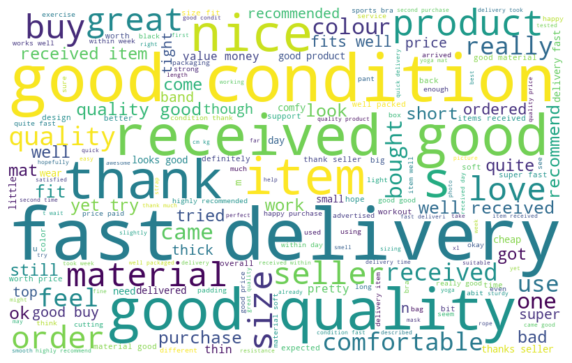

In [73]:
all_words = ' '.join([text for text in data_review['text']])
plot_wordCloud(all_words)

berikut ditampilkan seluruh review yang ada pada data review

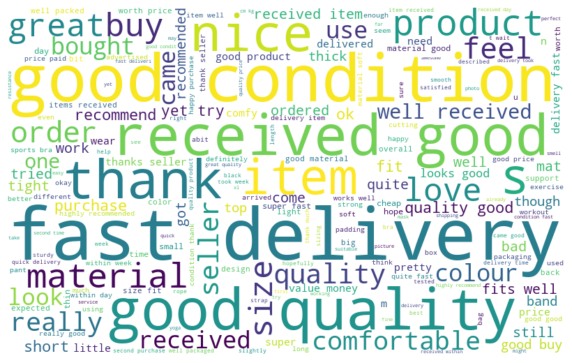

In [74]:
#untuk melihat kata kata yang normal atau netral
normal_words = ' '.join(text for text in data_review['text'][data_review['Sentimen'] == 'Positive']) 
plot_wordCloud(normal_words)

Untuk review positif, terlihat bahwa kata yang paling banyak muncul adalah fast delivery, good condition, good quality, received good, nice, dsb.

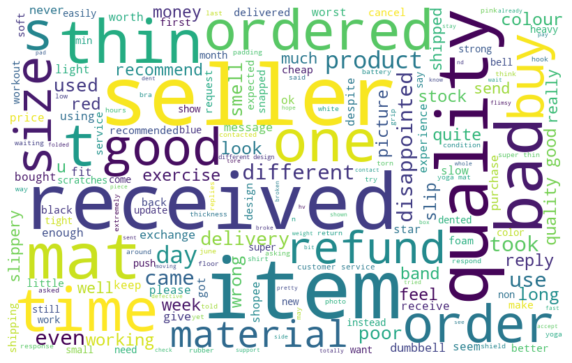

In [75]:
#untuk melihat kata kata yang normal atau netral
normal_words = ' '.join(text for text in data_review['text'][data_review['Sentimen'] == 'Negative']) 
plot_wordCloud(normal_words)

### Evaluasi Model

In [76]:
evaluasi_model_sentimen = pd.DataFrame(performance_model)
evaluasi_model_sentimen.columns = ['precision','recall','f1-score']

evaluasi_model_sentimen

,precision,recall,f1-score
0,1.00,0.98,0.99
1,1.00,0.98,0.99
2,1.00,0.97,0.98
3,1.00,0.98,0.99
4,1.00,0.96,0.98


Dari hasil tersebut untuk masing-masing model diberikan nilai precision, recall dan f1-score. Nilai precision untuk kelima model sama yaitu 1, nilai recall untuk model 1 adalah 0.98 dan nilai f1-score adalah 0.99. Nilai recall untuk model 2 adalah 0.98 dan nilai f1-score adalah 0.99. Nilai recall untuk model 3 adalah 0.97 dan nilai f1-score adalah 0.98. Nilai recall untuk model 4 adalah 0.98 dan nilai f1-score adalah 0.99. Nilai recall untuk model 5 adalah 0.96 dan nilai f1-score adalah 0.98. 


In [77]:
sumprecision = evaluasi_model_sentimen['precision'].astype(float)
avgprecision = sum(sumprecision)/len(sumprecision)

sumrecall = evaluasi_model_sentimen['recall'].astype(float)
avgrecall = sum(sumrecall)/len(sumrecall)

sumfscore = evaluasi_model_sentimen['f1-score'].astype(float)
avgfscore = sum(sumfscore)/len(sumfscore)

print ('precision', 'recall', 'fscore' )
print (avgprecision, avgrecall, avgfscore )

precision recall fscore
1.0 0.9739999999999999 0.986


#### F-score

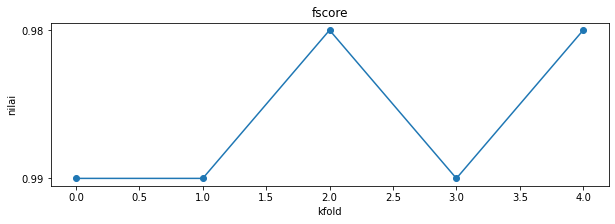

In [78]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,3))
plt.plot( evaluasi_model_sentimen['f1-score'], marker = "o" )
plt.title("fscore")
plt.xlabel("kfold")
plt.ylabel("nilai")


plt.show()

#### Recall

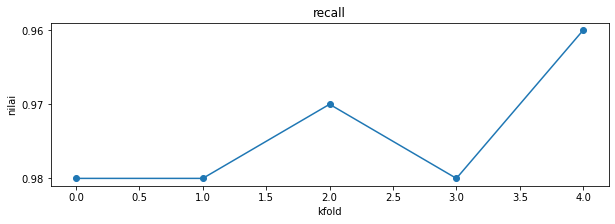

In [79]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,3))
plt.plot( evaluasi_model_sentimen.recall, marker = "o" )

plt.title("recall")
plt.xlabel("kfold")
plt.ylabel("nilai")

plt.show()

#### Precision

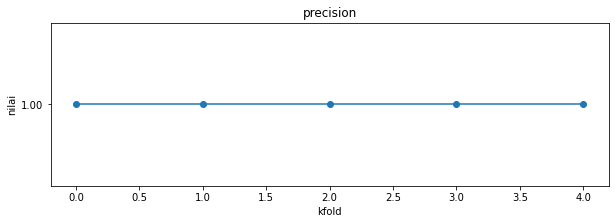

In [80]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,3))
plt.plot( evaluasi_model_sentimen.precision, marker = "o" )

plt.title("precision")
plt.xlabel("kfold")
plt.ylabel("nilai")

plt.show()

###### Hasil yang diperoleh dari model yang dibangun adalah kelima model sentimen dapat menganalisis dengan baik review pelanggan shopee yang bersentimen positif dan bersentimen negatif dengan nilai rata-rata precision adalah 1, nilai rata-rata recall adalah 0.973 dan nilai rata-rata f1-score adalah 0.986.